### Pre-processing

In [ ]:
import os
import cv2
import json
import random
import shutil
import pathlib
import numpy as np
from pathlib import Path

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

from sklearn.model_selection import KFold

from tqdm import tqdm
from typing import Callable, List, Optional, Tuple

In [ ]:
# Initialisation des générateurs de nombres aléatoires pour garantir la reproductibilité
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

Balancement des données :

In [ ]:
# Répertoire des vidéos originales et manipulées
dataset_dir = pathlib.Path('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset')
original_videos = dataset_dir / "DFD_original_sequences"
manipulated_videos = dataset_dir / "DFD_manipulated_sequences"

Les deux classes sont très débalancées (ratio de 1:10), on va devoir créer un nouveau dataset balancé pour ne pas que le modèle prédit seulement la classe manipulée.

In [ ]:
# Comptage des vidéos dans chaque répertoire
num_original_videos: int = len(list(original_videos.glob("*.mp4")))
num_manipulated_videos: int = len(list(manipulated_videos.glob("*.mp4")))
print(f"Original videos: {num_original_videos}")
print(f"Manipulated videos: {num_manipulated_videos}")

Original videos: 363
Manipulated videos: 3068


## Helper functions

In [ ]:
from PIL import Image

def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
    """Obtention d'un élément du jeu de données

    Récupère une image et son étiquette associée à l'indice spécifié.
    Les images sont simulées comme des tableaux NumPy. Une transformation peut être appliquée si définie.

    Paramètre(s)
    ----------
    idx : int
        Indice de l'élément à récupérer.

    Retourne
    -------
    Tuple[np.ndarray, int]
        Un tuple contenant l'image (après transformation si applicable) et l'étiquette associée.
    """
    label: int = self.labels[idx]
    # Données d'image fictives sous forme de tableau NumPy
    image: np.ndarray = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)  # Simulation d'une image
    if self.transform:
        image = self.transform(Image.fromarray(image))  # Conversion en image PIL
    return image, label

In [ ]:
def balance_dataset(original_videos_dir: Path, manipulated_videos_dir: Path, output_dir: Path, target_count: int = 75) -> Tuple[Tuple[List[Path], List[int]], Tuple[List[Path], List[int]]]:
    """Équilibrage du jeu de données

    Équilibre un jeu de données en sélectionnant un nombre égal de vidéos originales
    et DeepFake, puis les copie dans un répertoire de sortie.

    Paramètre(s)
    ----------
    original_videos_dir : Path
        Répertoire contenant les vidéos originales.
    manipulated_videos_dir : Path
        Répertoire contenant les vidéos DeepFake.
    output_dir : Path
        Répertoire où les vidéos équilibrées seront sauvegardées.
    target_count : int, optional
        Nombre de vidéos à sélectionner pour chaque classe, par défaut 75.

    Retourne
    -------
    Tuple[Tuple[List[Path], List[int]], Tuple[List[Path], List[int]]]
        Une paire de tuples contenant les listes de chemins des vidéos sélectionnées
        et leurs étiquettes correspondantes (0 pour originales, 1 pour DeepFake).
    """
    # Création des répertoires de sortie
    balanced_original_dir: Path = output_dir / "original"
    balanced_manipulated_dir: Path = output_dir / "manipulated"
    balanced_original_dir.mkdir(parents=True, exist_ok=True)
    balanced_manipulated_dir.mkdir(parents=True, exist_ok=True)
    # Échantillonnage des vidéos
    original_videos: List[Path] = list(original_videos_dir.glob("*.mp4"))
    manipulated_videos: List[Path] = list(manipulated_videos_dir.glob("*.mp4"))
    sampled_original: List[Path] = random.sample(original_videos, target_count)
    sampled_manipulated: List[Path] = random.sample(manipulated_videos, target_count)
    # Copie des vidéos échantillonnées dans les répertoires de sortie
    for file in sampled_original:
        shutil.copy(file, balanced_original_dir / file.name)
    for file in sampled_manipulated:
        shutil.copy(file, balanced_manipulated_dir / file.name)
    # print(f"Jeu de données équilibré créé avec {target_count} vidéos dans chaque classe.")
    return (sampled_original, [0] * len(sampled_original)), (sampled_manipulated, [1] * len(sampled_manipulated))

In [ ]:
# Nouvelle vérification du nombre de vidéos dans les répertoires
num_original_videos = len(list(original_videos.glob("*.mp4")))  # Modification de l'extension du fichier si nécessaire
num_manipulated_videos = len(list(manipulated_videos.glob("*.mp4")))
# Affichage du nombre de vidéos par catégorie
# print(f"Vidéos originelles : {num_original_videos}")
# print(f"Vidéos DeedFake : {num_manipulated_videos}")

In [ ]:
# Création des répertoires pour les vidéos équilibrées
balanced_dir: Path = pathlib.Path('./balanced_dataset')
balanced_samples: Tuple[Tuple[List[Path], List[int]], Tuple[List[Path], List[int]]] = balance_dataset(original_videos, manipulated_videos, balanced_dir, 150)
# Redéfinition des chemins pour les vidéos équilibrées
balanced_original: Path = balanced_dir / "original"
balanced_manipulated: Path = balanced_dir / "manipulated"
# S'assure que les répertoires de sortie existent
balanced_original.mkdir(parents=True, exist_ok=True)
balanced_manipulated.mkdir(parents=True, exist_ok=True)
# Mise à jour des chemins du jeu de données pour pointer vers le nouveau sous-ensemble
balanced_video_paths: List[Path] = []
balanced_labels: List[int] = []
for video_path in balanced_original.glob("*.mp4"):
    balanced_video_paths.append(video_path)
    balanced_labels.append(0)  # Étiquette 0 pour les vidéos originelles
for video_path in balanced_manipulated.glob("*.mp4"):
    balanced_video_paths.append(video_path)
    balanced_labels.append(1)  # Étiquette 1 pour les vidéos DeepFake
# Affichage de l'état du jeu de données équilibré
print(f"Balanced dataset created with 150 videos in each class.")
# print(f"Vidéos originelles enregistrées dans : {balanced_original}")
# print(f"Vidéos DeepFake enregistrées dans : {balanced_manipulated}")
# Vérification des vidéos après équilibrage
balanced_original_dir: Path = pathlib.Path('./balanced_dataset/original')
balanced_manipulated_dir: Path = pathlib.Path('./balanced_dataset/manipulated')
original_count = len(list(balanced_original_dir.glob("*.mp4")))
manipulated_count = len(list(balanced_manipulated_dir.glob("*.mp4")))
print(f"Number of videos in 'original' : {original_count}")
print(f"Number of videos in 'manipulated' : {manipulated_count}")

Balanced dataset created with 150 videos in each class.
Number of videos in 'original': 150
Number of videos in 'manipulated': 150


In [ ]:
class VideoDataset(Dataset):
    """Jeu de données pour charger des vidéos et leurs étiquettes associées

    Cette classe gère le chargement des images de vidéos, l'application
    d'éventuelles transformations, et la préparation des séquences pour
    des modèles d'apprentissage profond.

    Paramètre(s)
    ----------
    video_paths : List[Path]
        Liste des chemins des fichiers vidéo.
    labels : List[int]
        Liste des étiquettes correspondant à chaque vidéo.
    transform : Optional[Callable], optional
        Transformation à appliquer aux images, par défaut None.
    frames_per_video : int, optional
        Nombre d'images à charger par vidéo, par défaut 16.
    """

    def __init__(self, video_paths: List[Path], labels: List[int], transform: Optional[Callable] = None, frames_per_video: int = 16) -> None:
        self.video_paths: List[Path] = video_paths
        self.labels: List[int] = labels
        self.transform: Optional[Callable] = transform
        self.frames_per_video: int = frames_per_video

    def __len__(self) -> int:
        """Retourne la taille du jeu de données."""
        return len(self.video_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Retourne une séquence d'images et l'étiquette associée.

        Paramètre(s)
        ----------
        idx : int
            Indice de l'échantillon à récupérer.

        Retourne
        -------
        Tuple[torch.Tensor, int]
            Séquence d'images sous forme de tenseur PyTorch et étiquette associée.
        """
        video_path: Path = self.video_paths[idx]
        label: int = self.labels[idx]
        # Chargement de plusieurs images de la vidéo
        frames: List[np.ndarray] = self.load_video_frames(video_path, self.frames_per_video)
        # Application des transformations aux images
        if self.transform:
            frames = [self.transform(Image.fromarray(frame)) for frame in frames]
        # Empilage des images pour former une séquence
        frames_tensor: torch.Tensor = torch.stack(frames)
        return frames_tensor, label

    def load_video_frames(self, video_path: Path, num_frames: int) -> List[np.ndarray]:
        """Charge un nombre spécifique d'images d'une vidéo.

        Paramètre(s)
        ----------
        video_path : Path
            Chemin de la vidéo.
        num_frames : int
            Nombre de images à charger.

        Retourne
        -------
        List[np.ndarray]
            Liste des images sous forme de tableaux NumPy (en RGB).
        """
        cap: cv2.VideoCapture = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"Erreur lors de l'ouverture de la vidéo : {video_path}")
            return []  # Retourne une liste vide si la vidéo ne peut pas être ouverte
        frame_count: int = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices: np.ndarray = np.linspace(0, frame_count - 1, num_frames, dtype=np.int32)
        frames: List[np.ndarray] = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb: np.ndarray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            else:
                break
        cap.release()
        # S'il n'y a pas assez d'images, répétition de la dernière image
        if len(frames) < num_frames:
            frames += [frames[-1]] * (num_frames - len(frames))
        return frames

In [ ]:
# Transformations pour l'image (redimensionnement, normalisation, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Initialisation du jeu de données avec les vidéos et leurs étiquettes
balanced_dataset: VideoDataset = VideoDataset(balanced_video_paths, balanced_labels, transform=transform)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# Initialisation du SummaryWriter pour TensorBoard
writer: SummaryWriter = SummaryWriter(log_dir="runs/cross_validation")

In [ ]:
# Validation croisée en 3 plis
kf: KFold = KFold(n_splits=3, shuffle=True, random_state=1)
fold_splits: List[Tuple[np.ndarray, np.ndarray]] = [(train_idx, val_idx) for train_idx, val_idx in kf.split(balanced_video_paths)]

### Training

AlexNet pré-entraîné avec :
- Dropout
- LSTM

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import AlexNet_Weights

class AlexNetLSTM(nn.Module):
    """Combinaison d'un extracteur de caractéristiques basé sur AlexNet, d'un LSTM et d'un mécanisme d'attention pour la classification vidéo

    Cette architecture utilise AlexNet pour extraire les caractéristiques spatiales de chaque image,
    suivie d'un LSTM pour capturer les dépendances temporelles dans une séquence d'images, et un
    module d'attention pour pondérer les sorties temporelles du LSTM.

    Parameters
    ----------
    num_classes : int, optional
        Nombre de classes pour la classification, par défaut 2.
    lstm_hidden_size : int, optional
        Taille de la couche cachée du LSTM, par défaut 256.
    lstm_num_layers : int, optional
        Nombre de couches dans le LSTM, par défaut 1.
    freeze_feature_extractor : bool, optional
        Si True, gèle les poids de l'extracteur de caractéristiques AlexNet, par défaut True.

    Attributes
    ----------
    feature_extractor : nn.Module
        Extracteur de caractéristiques basé sur AlexNet.
    avgpool : nn.AdaptiveAvgPool2d
        Pooling adaptatif pour réduire les dimensions des caractéristiques.
    fc_features : nn.Sequential
        Couche linéaire pour réduire et normaliser les caractéristiques avant le LSTM.
    lstm : nn.LSTM
        Réseau LSTM pour capturer les dépendances temporelles.
    attention : nn.Sequential
        Module d'attention pour pondérer les sorties temporelles du LSTM.
    fc : nn.Sequential
        Couche linéaire pour la classification finale.
    """

    def __init__(self, num_classes: int = 2, lstm_hidden_size: int = 256, lstm_num_layers: int = 1, freeze_feature_extractor: bool = True) -> None:
        super(AlexNetLSTM, self).__init__()
        # Chargement des caractéristiques d'AlexNet pré-entraîné
        self.feature_extractor: nn.Module = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).features
        self.avgpool: nn.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((6, 6))
        # Réduction des dimensions des caractéristiques avec normalisation et dropout
        self.fc_features: nn.Sequential = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),  # AlexNet produit 256 cartes de taille 6x6
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        # Optionnel : geler l'extracteur de caractéristiques
        if freeze_feature_extractor:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        # LSTM pour la modélisation temporelle
        self.lstm: nn.LSTM = nn.LSTM(
            input_size=1024,  # Taille des caractéristiques en entrée
            hidden_size=lstm_hidden_size,  # Taille de la couche cachée
            num_layers=lstm_num_layers,  # Nombre de couches LSTM
            batch_first=True  # L'entrée est de la forme (batch_size, seq_len, features)
        )
        # Mécanisme d'attention pour pondérer les sorties temporelles du LSTM
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)  # Normalisation des poids d'attention sur la dimension temporelle
        )
        # Couche de classification finale
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Prédiction finale des classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Passe avant du modèle.

        Paramètre(s)
        ----------
        x : torch.Tensor
            Tenseur d'entrée de forme (batch_size, seq_len, c, h, w), où :
            - batch_size : Taille du lot
            - seq_len : Longueur de la séquence temporelle
            - c : Nombre de canaux (typiquement 3 pour RGB)
            - h : Hauteur de l'image
            - w : Largeur de l'image

        Retourne
        -------
        torch.Tensor
            Prédictions de forme (batch_size, num_classes).
        """
        batch_size, seq_len, c, h, w = x.size()
        # Redimensionnement de l'entrée pour l'extracteur de caractéristiques
        x = x.view(batch_size * seq_len, c, h, w)
        features: torch.Tensor = self.feature_extractor(x)
        # Pooling adaptatif et aplatissage
        features = self.avgpool(features)
        features = torch.flatten(features, start_dim=1)
        features = self.fc_features(features)
        # Redimensionnement pour l'entrée du LSTM
        features = features.view(batch_size, seq_len, -1)
        # Aplatissage des poids du LSTM (optimisation pour CuDNN)
        self.lstm.flatten_parameters()
        # Passage avant à travers le LSTM
        lstm_out, _ = self.lstm(features)  # lstm_out : (batch_size, seq_len, lstm_hidden_size)
        # Application du mécanisme d'attention
        attention_weights: torch.Tensor = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        context_vector: torch.Tensor = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, lstm_hidden_size)
        # Passage final à travers le classifieur
        output: torch.Tensor = self.fc(context_vector)
        return output

In [ ]:
# Détection du périphérique pour l'entraînement (GPU si disponible)
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model: nn.Module = AlexNetLSTM(num_classes=2).to(device)
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: torch.optim.Adam = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
def train_and_validate(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int, fold_idx: int, writer: SummaryWriter, patience: int = 5) -> Tuple[float, Optional[dict], List[float], List[float]]:
    """Entraînement et validation d'un modèle PyTorch sur plusieurs époques

    Cette fonction alterne entre les étapes d'entraînement et de validation à chaque époque,
    en affichant les pertes et la précision à la fin de chaque phase.

    Paramètre(s)
    ----------
    model : nn.Module
        Le modèle PyTorch à entraîner.
    train_loader : DataLoader
        DataLoader pour l'ensemble d'entraînement.
    val_loader : DataLoader
        DataLoader pour l'ensemble de validation.
    epochs : int
        Nombre d'époques pour l'entraînement.
    fold_idx : int
        Indice du pli pour le logging.
    writer : SummaryWriter
        Writer pour enregistrer les métriques dans TensorBoard.
    patience : int, optional
        Nombre d'époques sans amélioration avant l'arrêt anticipé, par défaut 5.

    Retourne
    -------
    Tuple[float, Optional[dict], List[float], List[float]]
        - Meilleure précision sur les données de validation.
        - État du modèle correspondant à la meilleure précision.
        - Liste des pertes d'entraînement par époque.
        - Liste des pertes de validation par époque.
    """
    train_losses: List[float] = []
    val_losses: List[float] = []
    best_epoch_accuracy: float = 0.0
    best_model_state: Optional[dict] = None
    epochs_no_improve: int = 0
    for epoch in range(epochs):
        model.train()  # Passe le modèle en mode entraînement
        running_train_loss: float = 0.0
         # Boucle d'entraînement avec barre de progression
        print(f"Epoch {epoch + 1}/{epochs}")
        train_progress = tqdm(train_loader, desc="Training")
        for videos, labels in train_progress:
            videos, labels = videos.to(device), labels.to(device)
            # Passage avant
            optimizer.zero_grad()
            outputs: torch.Tensor = model(videos)
            loss: torch.Tensor = criterion(outputs, labels)
            # Rétropropagation et mise à jour de l'optimiseur
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            train_progress.set_postfix(loss=loss.item())
        avg_train_loss: float = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # Boucle de validation
        model.eval()  # Passe le modèle en mode évaluation
        val_loss: float = 0.0
        correct: int = 0
        total: int = 0
        with torch.no_grad():
            val_progress = tqdm(val_loader, desc="Validating")
            for videos, labels in val_progress:
                videos, labels = videos.to(device), labels.to(device)
                # Passage avant
                outputs: torch.Tensor = model(videos)
                loss: torch.Tensor = criterion(outputs, labels)
                val_loss += loss.item()
                # Calcul de la précision
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_val_loss: float = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy: float = correct / total
        print(
            f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
        # Enregistrement des métriques dans TensorBoard
        writer.add_scalar(f"Fold_{fold_idx}/Train_Loss", avg_train_loss, epoch + 1)
        writer.add_scalar(f"Fold_{fold_idx}/Val_Loss", avg_val_loss, epoch + 1)
        writer.add_scalar(f"Fold_{fold_idx}/Val_Accuracy", val_accuracy, epoch + 1)
        # Vérifie l'amélioration
        if val_accuracy > best_epoch_accuracy:
            best_epoch_accuracy = val_accuracy
            best_model_state = model.state_dict()  # Sauvegarde l'état du meilleur modèle
            epochs_no_improve = 0
            print(f"New best validation accuracy: {val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
        # Arrêt anticipé
        if epochs_no_improve >= patience:
            print(
                f"Early stopping triggered after {epoch + 1} epochs. "
                f"No improvement for {patience} consecutive epochs."
            )
            break
    return best_epoch_accuracy, best_model_state, train_losses, val_losses

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model: nn.Module, val_loader: DataLoader) -> Tuple[np.ndarray, float, float, float, float]:
    """Évaluation d'un modèle PyTorch sur un ensemble de validation

    Cette fonction calcule les métriques de classification (matrice de confusion, précision,
    rappel, score F1) en collectant les prédictions et les étiquettes réelles.

    Paramètre(s)
    ----------
    model : nn.Module
        Le modèle PyTorch à évaluer.
    val_loader : DataLoader
        DataLoader pour l'ensemble de validation.

    Retourne
    -------
    Tuple[np.ndarray, float, float, float, float]
        - Matrice de confusion (2x2) sous forme de tableau NumPy.
        - Précision globale (accuracy).
        - Précision pondérée (precision).
        - Rappel pondéré (recall).
        - Score F1 pondéré (f1_score).
    """
    y_true: List[int] = []
    y_pred: List[int] = []
    tp: int = 0  # Vrais positifs
    tn: int = 0  # Vrais négatifs
    fp: int = 0  # Faux positifs
    fn: int = 0  # Faux négatifs
    # Collecte des prédictions et des vraies étiquettes
    model.eval()
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs: torch.Tensor = model(videos)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            tp += ((preds == 1) & (labels == 1)).sum().item()
            tn += ((preds == 0) & (labels == 0)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()
    # Calcul des métriques
    acc: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall: float = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1: float = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    cm: np.ndarray = np.array([[tp, fn], [fp, tn]])
    return cm, acc, precision, recall, f1

In [ ]:
# Dictionnaire pour stocker les métriques des différents plis
metrics = {
    "accuracy": [],
    "preision": [],
    "recall": [],
    "f1_score": []
}

In [ ]:
# Sélection des indices pour l'entraînement et la validation
train_idx: List[int] = list(range(0, 240))  # Ajustement selon le jeu de données
val_idx: List[int] = list(range(240, 300))
train_dataset: Subset = Subset(balanced_dataset, train_idx)
val_dataset: Subset = Subset(balanced_dataset, val_idx)
# Initialisation des DataLoaders
train_loader: DataLoader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader: DataLoader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [ ]:
def plot_confusion_matrix(cm: np.ndarray, labels: List[str] = ["Positive", "Negative"]) -> None:
    """Affichage d'une matrice de confusion sous forme de carte thermique (heatmap)

    Cette fonction prend une matrice de confusion sous forme de tableau NumPy
    et la visualise en utilisant `seaborn` et `matplotlib`.

    Paramètre(s)
    ----------
    cm : np.ndarray
        Matrice de confusion (2x2) sous forme de tableau NumPy.
    labels : List[str], optional
        Liste des étiquettes à afficher pour les axes x et y. Par défaut, ["Positive", "Negative"].
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues', 
        xticklabels=labels, 
        yticklabels=labels
    )
    plt.ylabel("Predicted Values")
    plt.xlabel("Actual Values")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def plot_loss_curves(train_losses: List[float], val_losses: List[float], fold_idx: int) -> None:
    """Affichage des courbes de perte pour l'entraînement et la validation

    Cette fonction génère un graphique montrant l'évolution des pertes d'entraînement
    et de validation en fonction des époques pour un pli donné (fold).

    Paramètre(s)
    ----------
    train_losses : List[float]
        Liste contenant les valeurs de la perte d'entraînement pour chaque époque.
    val_losses : List[float]
        Liste contenant les valeurs de la perte de validation pour chaque époque.
    fold_idx : int
        Index du pli (fold) en cours, utilisé pour annoter le titre du graphique.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.title(f"Loss Curves for Fold {fold_idx}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


Fold 1:
Epoch 1/10


Validating: 100%|██████████| 13/13 [15:39<00:00, 72.24s/it]


Epoch 1 - Train Loss: 0.8390, Val Loss: 0.7365, Val Accuracy: 0.5300
New best validation accuracy: 0.5300
Epoch 2/10


Validating: 100%|██████████| 13/13 [15:38<00:00, 72.22s/it]


Epoch 2 - Train Loss: 0.6946, Val Loss: 0.7122, Val Accuracy: 0.4900
Epoch 3/10


Validating: 100%|██████████| 13/13 [15:37<00:00, 72.14s/it]


Epoch 3 - Train Loss: 0.5692, Val Loss: 0.8072, Val Accuracy: 0.5200
Epoch 4/10


Validating: 100%|██████████| 13/13 [15:32<00:00, 71.73s/it]


Epoch 4 - Train Loss: 0.5469, Val Loss: 0.8437, Val Accuracy: 0.4900
Epoch 5/10


Validating: 100%|██████████| 13/13 [15:38<00:00, 72.17s/it]


Epoch 5 - Train Loss: 0.5282, Val Loss: 0.8900, Val Accuracy: 0.5700
New best validation accuracy: 0.5700
Epoch 6/10


Validating: 100%|██████████| 13/13 [15:37<00:00, 72.12s/it]


Epoch 6 - Train Loss: 0.4564, Val Loss: 1.1324, Val Accuracy: 0.4600
Epoch 7/10


Validating: 100%|██████████| 13/13 [15:35<00:00, 71.96s/it]


Epoch 7 - Train Loss: 0.4579, Val Loss: 1.0840, Val Accuracy: 0.5100
Epoch 8/10


Validating: 100%|██████████| 13/13 [15:37<00:00, 72.08s/it]


Epoch 8 - Train Loss: 0.4523, Val Loss: 0.9875, Val Accuracy: 0.5700
Epoch 9/10


Validating: 100%|██████████| 13/13 [15:36<00:00, 72.06s/it]


Epoch 9 - Train Loss: 0.3871, Val Loss: 1.1418, Val Accuracy: 0.4900
Epoch 10/10


Validating: 100%|██████████| 13/13 [15:34<00:00, 71.86s/it]


Epoch 10 - Train Loss: 0.3729, Val Loss: 1.0801, Val Accuracy: 0.5500
Early stopping triggered after 10 epochs. No improvement for 5 consecutive epochs.


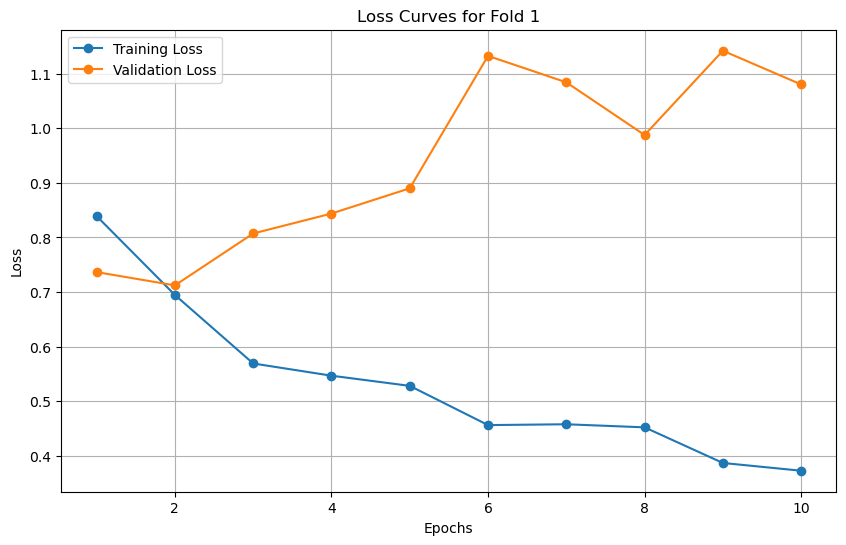

Metrics for Fold 1:
Accuracy: 0.5500
Precision: 0.5573
Recall: 0.5500
F1 Score: 0.5509
Confusion Matrix for Fold 1:
[[26 19]
 [26 29]]


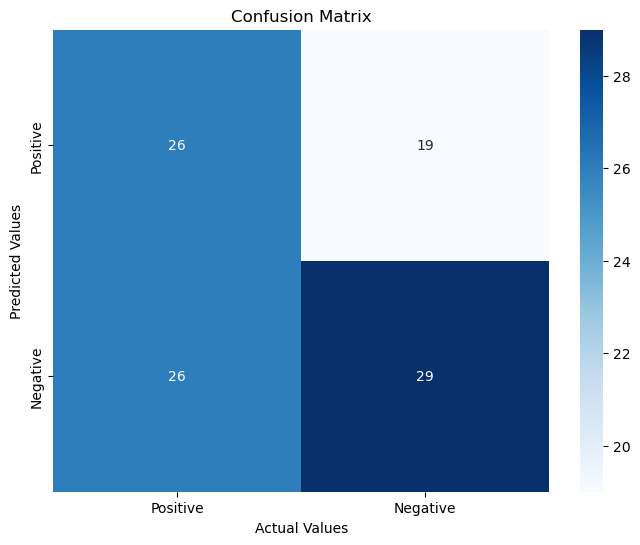

Updated overall best accuracy to 0.5700 at Fold 1

Fold 2:
Epoch 1/10


Validating: 100%|██████████| 13/13 [15:26<00:00, 71.29s/it]


Epoch 1 - Train Loss: 0.8197, Val Loss: 0.7387, Val Accuracy: 0.4300
New best validation accuracy: 0.4300
Epoch 2/10


Validating: 100%|██████████| 13/13 [15:26<00:00, 71.26s/it]


Epoch 2 - Train Loss: 0.6363, Val Loss: 0.8520, Val Accuracy: 0.4600
New best validation accuracy: 0.4600
Epoch 3/10


Validating: 100%|██████████| 13/13 [15:24<00:00, 71.13s/it]


Epoch 3 - Train Loss: 0.6049, Val Loss: 0.8454, Val Accuracy: 0.4900
New best validation accuracy: 0.4900
Epoch 4/10


Validating: 100%|██████████| 13/13 [15:24<00:00, 71.15s/it]


Epoch 4 - Train Loss: 0.4819, Val Loss: 0.8917, Val Accuracy: 0.5200
New best validation accuracy: 0.5200
Epoch 5/10


Validating: 100%|██████████| 13/13 [15:18<00:00, 70.69s/it]


Epoch 5 - Train Loss: 0.4635, Val Loss: 0.9341, Val Accuracy: 0.5700
New best validation accuracy: 0.5700
Epoch 6/10


Validating: 100%|██████████| 13/13 [15:25<00:00, 71.18s/it]


Epoch 6 - Train Loss: 0.4654, Val Loss: 1.0031, Val Accuracy: 0.5100
Epoch 7/10


Validating: 100%|██████████| 13/13 [15:25<00:00, 71.18s/it]


Epoch 7 - Train Loss: 0.3965, Val Loss: 1.0362, Val Accuracy: 0.5700
Epoch 8/10


Validating: 100%|██████████| 13/13 [15:28<00:00, 71.44s/it]


Epoch 8 - Train Loss: 0.3776, Val Loss: 1.0220, Val Accuracy: 0.6100
New best validation accuracy: 0.6100
Epoch 9/10


Validating: 100%|██████████| 13/13 [15:27<00:00, 71.36s/it]


Epoch 9 - Train Loss: 0.3565, Val Loss: 1.1232, Val Accuracy: 0.5200
Epoch 10/10


Validating: 100%|██████████| 13/13 [15:26<00:00, 71.24s/it]

Epoch 10 - Train Loss: 0.3645, Val Loss: 1.1593, Val Accuracy: 0.6000


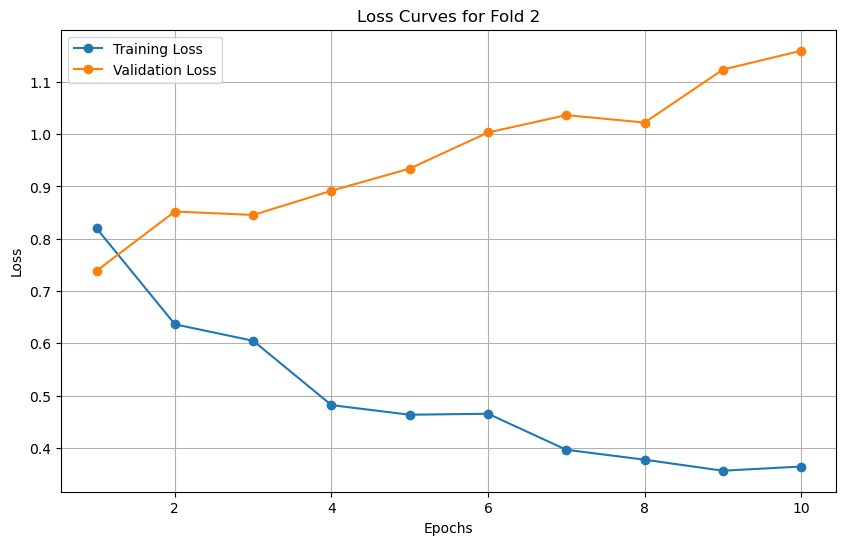

Metrics for Fold 2:
Accuracy: 0.6000
Precision: 0.6019
Recall: 0.6000
F1 Score: 0.6000
Confusion Matrix for Fold 2:
[[30 18]
 [22 30]]


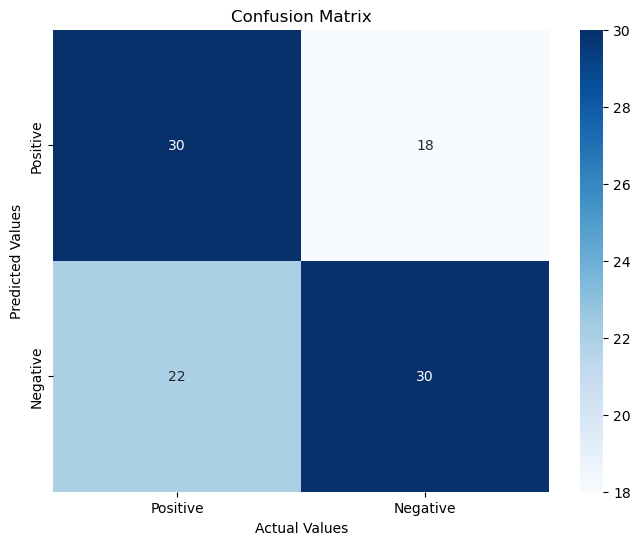

Updated overall best accuracy to 0.6100 at Fold 2

Fold 3:
Epoch 1/10


Validating: 100%|██████████| 13/13 [15:32<00:00, 71.70s/it]


Epoch 1 - Train Loss: 0.7981, Val Loss: 0.7025, Val Accuracy: 0.5300
New best validation accuracy: 0.5300
Epoch 2/10


Validating: 100%|██████████| 13/13 [15:30<00:00, 71.55s/it]


Epoch 2 - Train Loss: 0.6612, Val Loss: 0.7665, Val Accuracy: 0.5000
Epoch 3/10


Validating: 100%|██████████| 13/13 [15:22<00:00, 70.98s/it]


Epoch 3 - Train Loss: 0.6222, Val Loss: 0.7560, Val Accuracy: 0.5700
New best validation accuracy: 0.5700
Epoch 4/10


Validating: 100%|██████████| 13/13 [15:27<00:00, 71.34s/it]


Epoch 4 - Train Loss: 0.5188, Val Loss: 0.8538, Val Accuracy: 0.5200
Epoch 5/10


Validating: 100%|██████████| 13/13 [15:43<00:00, 72.57s/it]


Epoch 5 - Train Loss: 0.5036, Val Loss: 0.9109, Val Accuracy: 0.5200
Epoch 6/10


Validating: 100%|██████████| 13/13 [15:23<00:00, 71.05s/it]


Epoch 6 - Train Loss: 0.4870, Val Loss: 0.9152, Val Accuracy: 0.5500
Epoch 7/10


Validating: 100%|██████████| 13/13 [15:36<00:00, 72.00s/it]


Epoch 7 - Train Loss: 0.4466, Val Loss: 0.9780, Val Accuracy: 0.4900
Epoch 8/10


Validating: 100%|██████████| 13/13 [15:37<00:00, 72.13s/it]

Epoch 8 - Train Loss: 0.3978, Val Loss: 1.0223, Val Accuracy: 0.5400
Early stopping triggered after 8 epochs. No improvement for 5 consecutive epochs.


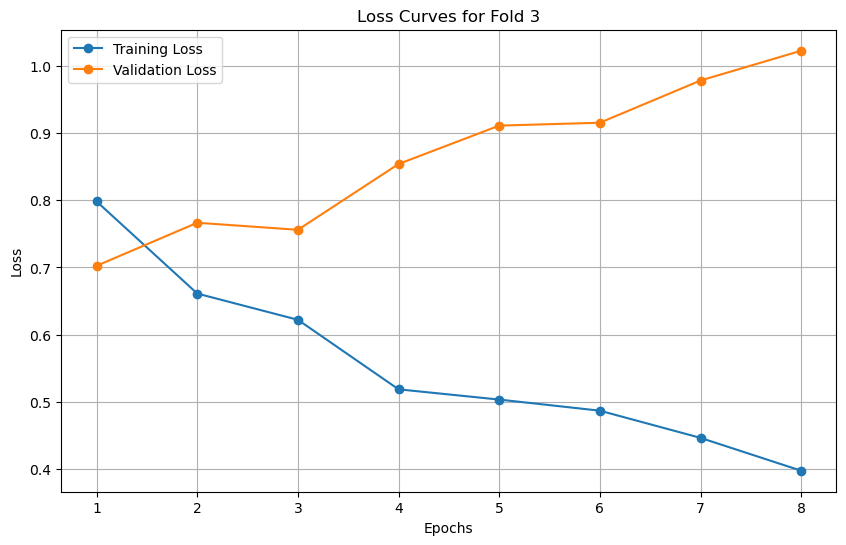

Metrics for Fold 3:
Accuracy: 0.5400
Precision: 0.5483
Recall: 0.5400
F1 Score: 0.5422
Confusion Matrix for Fold 3:
[[31 26]
 [20 23]]


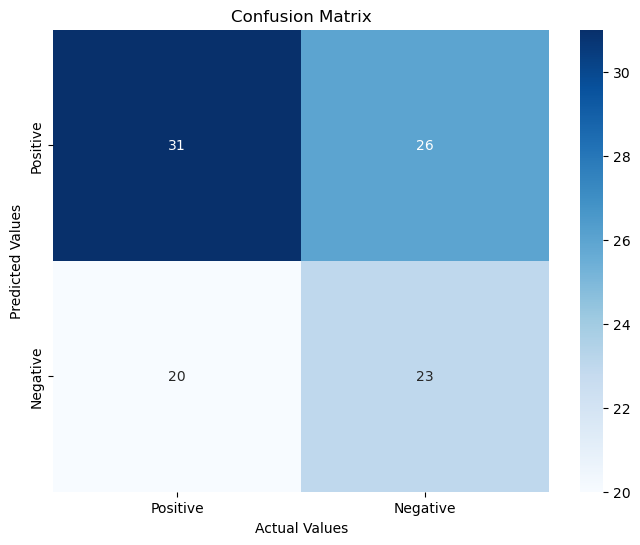

Loaded the best model with accuracy 0.6100


In [ ]:
best_accuracy = 0.0 
best_model_state = None  
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
    print(f"\nFold {fold_idx + 1}:")
    # Préparation des DataLoaders pour le pli
    train_dataset = Subset(balanced_dataset, train_idx)
    val_dataset = Subset(balanced_dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
    # Initialisation du modèle et de l'optimiseur pour chaque pli
    model = AlexNetLSTM(num_classes=2).to(device)
    model.lstm.flatten_parameters()
    optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    criterion = nn.CrossEntropyLoss()
     # Entraînement et validation pour le pli
    fold_best_accuracy, fold_best_model_state, train_losses, val_losses = train_and_validate(
        model,
        train_loader,
        val_loader,
        epochs=10,
        fold_idx=fold_idx + 1,
        writer=writer
    )
    # Trace les courbes de perte pour le pli
    plot_loss_curves(train_losses, val_losses, fold_idx + 1)
    # Évaluation des métriques finales pour le pli
    cm, acc, precision, recall, f1 = evaluate_model(model, val_loader)
    # Affichage des métriques du pli
    print(f"Metrics for Fold {fold_idx + 1}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix for Fold {fold_idx + 1}:\n{cm}")
    plot_confusion_matrix(cm, labels=["Positive", "Negative"])
    # Mise à jour du meilleur modèle global en fonction de la précision de validation
    if fold_best_accuracy > best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model_state = fold_best_model_state
        print(f"Updated overall best accuracy to {best_accuracy:.4f} at Fold {fold_idx + 1}")
# Après tous les plis, chargement du meilleur modèle pour un entraînement ou une évaluation ultérieurs
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded the best model with accuracy {best_accuracy:.4f}")

In [ ]:
# Sauvegarde du meilleur modèle
torch.save(model.state_dict(), '/kaggle/working//alexnet_best_model.pth')

In [ ]:
# Fermeture de TensorBoard
writer.close()